In [67]:
# %pip install --upgrade "accelerate>=0.26.0"

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import itertools
from nltk.corpus import stopwords
import nltk

import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from sklearn.metrics import classification_report

In [69]:
print(torch.cuda.is_available())  # Should return True

True


In [70]:
train_df = pd.read_csv("data/medical_tc_train.csv")
test_df = pd.read_csv("data/medical_tc_test.csv")

In [71]:
train_df['abstract_length'] = train_df['medical_abstract'].apply(lambda x: len(x.split()))

labels = [
    train_df['condition_label'] == 1,
    train_df['condition_label'] == 2,
    train_df['condition_label'] == 3,
    train_df['condition_label'] == 4,
    train_df['condition_label'] == 5]

names = ['Neoplasms', 'Digestive System Disease', 'Nervous System Disease', 'Cardiovascular Disease', 'General Pathological Conditions']

train_df['condition_name'] = np.select(labels, names, default ='unknown')

column_order = ['condition_label', 'condition_name', 'medical_abstract', 'abstract_length']
train_df = train_df[column_order]

print("The 5 different types of diseases are as follows:")
for disease in train_df['condition_name'].unique():
    print(disease)

The 5 different types of diseases are as follows:
General Pathological Conditions
Neoplasms
Digestive System Disease
Nervous System Disease
Cardiovascular Disease


In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   11550 non-null  int64 
 1   condition_name    11550 non-null  object
 2   medical_abstract  11550 non-null  object
 3   abstract_length   11550 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 361.1+ KB


In [73]:
train_df.head()

,condition_label,condition_name,medical_abstract,abstract_length
0,5,General Pathological Conditions,Tissue changes around loose prostheses. A cani...,156
1,1,Neoplasms,Neuropeptide Y and neuron-specific enolase lev...,187
2,2,Digestive System Disease,"Sexually transmitted diseases of the colon, re...",256
3,1,Neoplasms,Lipolytic factors associated with murine and h...,146
4,3,Nervous System Disease,Does carotid restenosis predict an increased r...,233


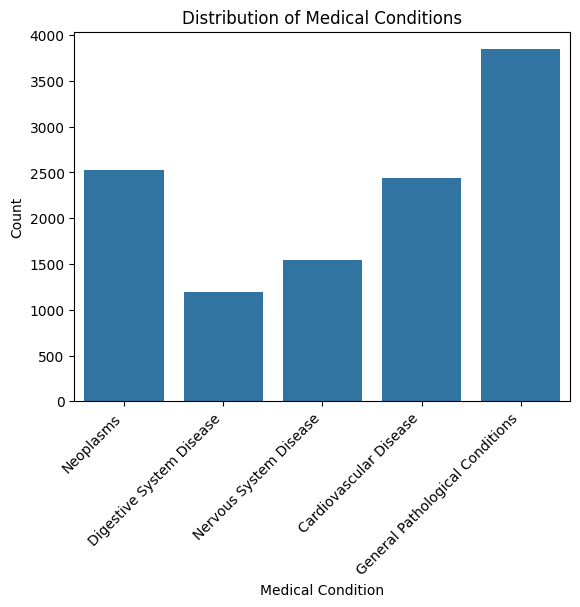

In [74]:
label_order = ['Neoplasms', 'Digestive System Disease', 'Nervous System Disease', 'Cardiovascular Disease', 'General Pathological Conditions']

sns.countplot(train_df, x='condition_name', order=label_order)
plt.title('Distribution of Medical Conditions')
plt.xlabel('Medical Condition')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

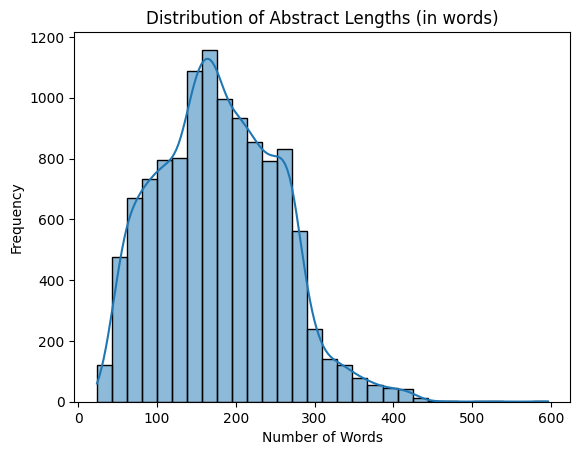

In [75]:
sns.histplot(train_df['abstract_length'], bins=30, kde=True)
plt.title('Distribution of Abstract Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

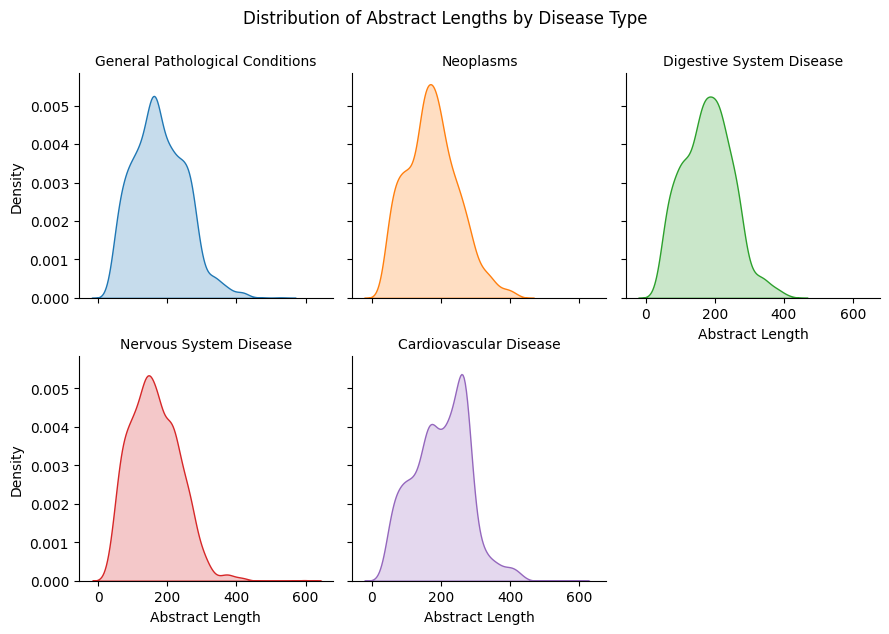

In [76]:
s = sns.FacetGrid(train_df, col='condition_name', col_wrap=3, hue='condition_name')
s.map(sns.kdeplot, 'abstract_length', fill=True)
s.set_axis_labels('Abstract Length', 'Density')
s.set_titles(col_template="{col_name}")
s.figure.suptitle('Distribution of Abstract Lengths by Disease Type', y=1.05)
plt.show()

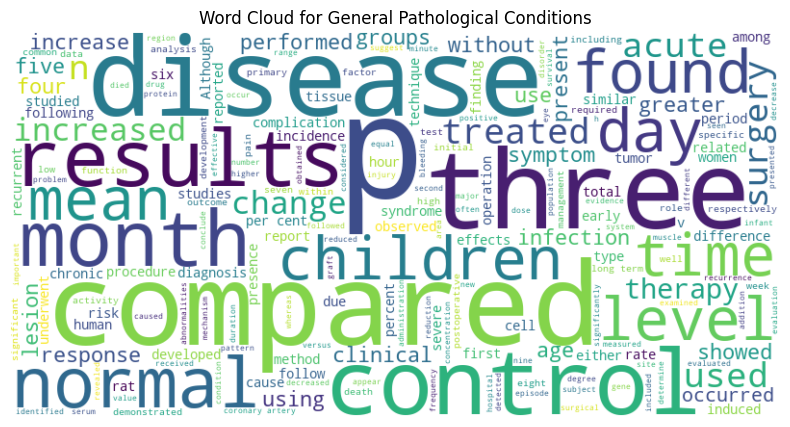

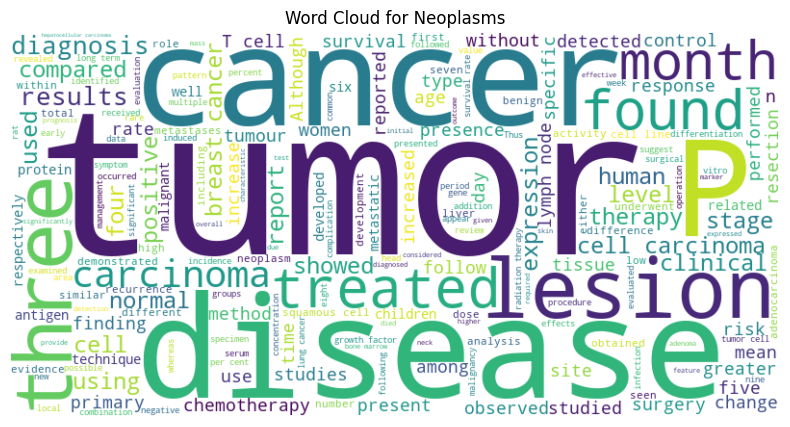

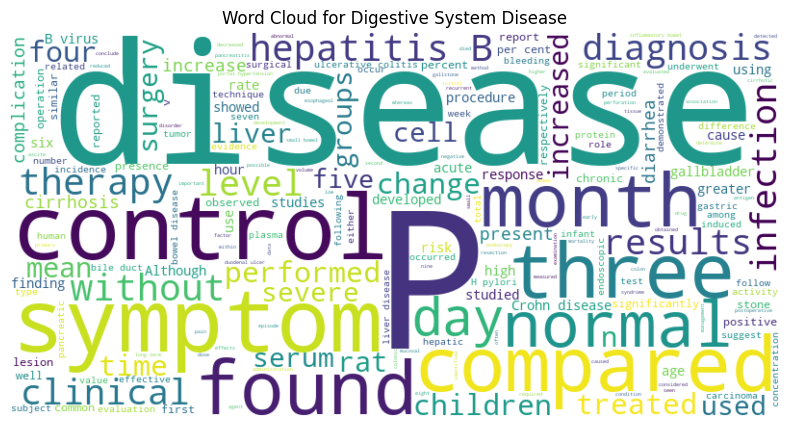

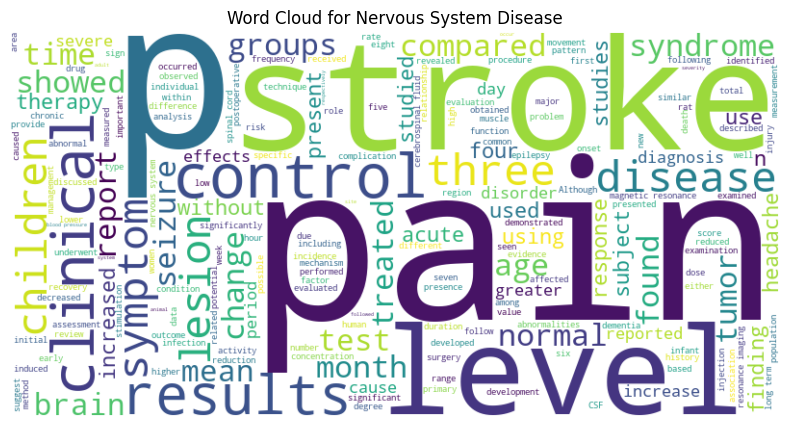

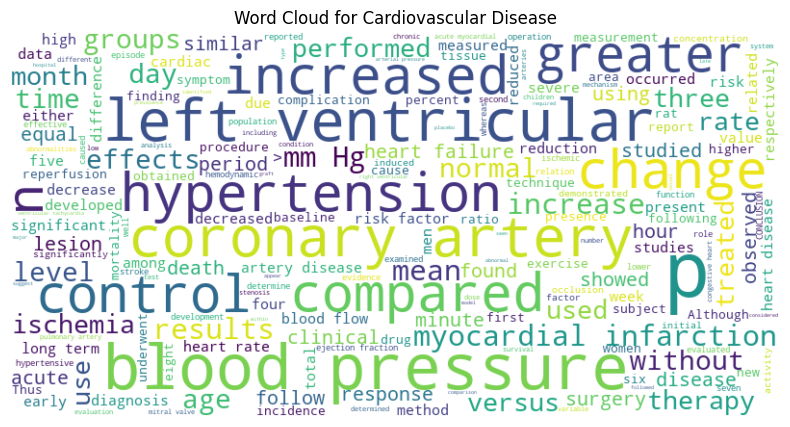

In [77]:
remove_words = {'patient', 'patients', 'two', 'one', 'may', 'study', 'group', 'treatment', 'case', 'cases', 'year', 'years', 'less', 'result', 'effect', 'associated'}
all_stopwords = STOPWORDS.union(remove_words)

for label in train_df['condition_name'].unique():
    text = " ".join(train_df[train_df['condition_name'] == label]['medical_abstract'])
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=all_stopwords  
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}')
    plt.show()


In [78]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
additional_words = {'patient', 'patients', 'two', 'one', 'may', 'study', 'group', 'treatment', 'case', 'cases', 'year', 'years', 'less', 'result', 'effect', 'associated'}
all_stopwords = stop_words.union(additional_words)

for label in train_df['condition_label'].unique():
    words = list(itertools.chain(*train_df[train_df['condition_label'] == label]['medical_abstract'].str.lower().str.split()))
    
    filtered_words = [word for word in words if word.isalpha() and word not in all_stopwords]
    
    common_words = Counter(filtered_words).most_common(10)
    
    print(f'\nTop 10 words for Disease Type {label}:')
    for word, freq in common_words:
        print(f'{word}: {freq}')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deshr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top 10 words for Disease Type 5:
acute: 1142
clinical: 1043
blood: 986
results: 890
disease: 885
three: 868
significantly: 866
chronic: 843
significant: 828
normal: 808

Top 10 words for Disease Type 1:
tumor: 1649
cell: 1612
cancer: 1395
cells: 1300
carcinoma: 1024
tumors: 907
human: 847
survival: 764
clinical: 755
primary: 717

Top 10 words for Disease Type 2:
disease: 552
liver: 495
gastric: 372
chronic: 356
significantly: 333
hepatitis: 316
normal: 314
hepatic: 312
clinical: 309
acute: 307

Top 10 words for Disease Type 3:
cerebral: 498
clinical: 495
brain: 450
pain: 430
disease: 393
normal: 342
significantly: 328
results: 319
significant: 303
three: 299

Top 10 words for Disease Type 4:
coronary: 1986
blood: 1676
ventricular: 1612
pressure: 1330
heart: 1305
artery: 1296
left: 1266
myocardial: 1253
cardiac: 1111
p: 905


In [79]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [80]:
# Tokenize text
train_encodings = tokenizer(list(train_df['medical_abstract']),
                            truncation=True,
                            padding=True,
                            max_length=128)

test_encodings = tokenizer(list(test_df['medical_abstract']),
                           truncation=True,
                           padding=True,
                           max_length=128)

In [81]:
class MedicalDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_labels = train_df['condition_label'].tolist()
test_labels = test_df['condition_label'].tolist()

train_dataset = MedicalDataset(train_encodings, train_labels)
test_dataset = MedicalDataset(test_encodings, test_labels)

In [82]:
num_labels = max(train_labels) + 1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_dir='./logs',
    load_best_model_at_end=True
)

c:\Users\deshr\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [84]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [102]:
trainer.train()

#Step 10: Evaluate
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)

#Step 11: Report
print(classification_report(test_labels, preds.tolist()))

 23%|██▎       | 500/2166 [03:11<11:10,  2.49it/s]

{'loss': 1.0737, 'grad_norm': 11.659200668334961, 'learning_rate': 3.845798707294552e-05, 'epoch': 0.69}


                                                  
 33%|███▎      | 722/2166 [05:01<09:31,  2.53it/s]

{'eval_loss': 0.9256858825683594, 'eval_runtime': 20.2447, 'eval_samples_per_second': 142.655, 'eval_steps_per_second': 8.941, 'epoch': 1.0}


 46%|████▌     | 1000/2166 [06:57<07:57,  2.44it/s] 

{'loss': 0.8637, 'grad_norm': 5.55762243270874, 'learning_rate': 2.6915974145891044e-05, 'epoch': 1.39}


                                                   
 67%|██████▋   | 1444/2166 [10:19<04:45,  2.53it/s]

{'eval_loss': 0.8760067224502563, 'eval_runtime': 20.2336, 'eval_samples_per_second': 142.733, 'eval_steps_per_second': 8.946, 'epoch': 2.0}


 69%|██████▉   | 1500/2166 [10:43<04:32,  2.44it/s]  

{'loss': 0.7872, 'grad_norm': 7.142364978790283, 'learning_rate': 1.5373961218836565e-05, 'epoch': 2.08}


 92%|█████████▏| 2000/2166 [14:07<01:07,  2.46it/s]

{'loss': 0.6691, 'grad_norm': 4.937306880950928, 'learning_rate': 3.831948291782087e-06, 'epoch': 2.77}


                                                   
100%|██████████| 2166/2166 [15:36<00:00,  2.56it/s]

{'eval_loss': 0.9126555919647217, 'eval_runtime': 20.0454, 'eval_samples_per_second': 144.073, 'eval_steps_per_second': 9.03, 'epoch': 3.0}


100%|██████████| 2166/2166 [15:38<00:00,  2.31it/s]


{'train_runtime': 938.4461, 'train_samples_per_second': 36.923, 'train_steps_per_second': 2.308, 'train_loss': 0.833615856927958, 'epoch': 3.0}


100%|██████████| 181/181 [00:20<00:00,  9.04it/s]


              precision    recall  f1-score   support

           1       0.69      0.80      0.74       633
           2       0.52      0.72      0.61       299
           3       0.59      0.61      0.60       385
           4       0.65      0.86      0.74       610
           5       0.63      0.35      0.45       961

    accuracy                           0.63      2888
   macro avg       0.62      0.67      0.63      2888
weighted avg       0.63      0.63      0.61      2888



### Using GRU (PyTorch)

In [86]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [87]:
class GRUClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=6):  # Adjust num_classes based on your labels
        super().__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(2 * hidden_dim, 128)
        self.bn = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.3)
        self.out = nn.Linear(128, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.pool(out.transpose(1, 2)).squeeze(-1)
        out = self.drop1(out)
        out = self.fc1(out)
        out = self.bn(out)
        out = self.drop2(out)
        return self.out(out)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUClassifier(hidden_dim=128, num_classes=6).to(device)

In [88]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.to(device)
bert.eval() 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Training Loss: {total_loss:.4f}")


model.eval()
all_preds = []
all_labels = []

100%|██████████| 722/722 [03:46<00:00,  3.19it/s]


Epoch 1 Training Loss: 1164.3032


100%|██████████| 722/722 [03:58<00:00,  3.03it/s]


Epoch 2 Training Loss: 923.1948


100%|██████████| 722/722 [04:01<00:00,  3.00it/s]


Epoch 3 Training Loss: 825.1310


100%|██████████| 722/722 [04:03<00:00,  2.97it/s]


Epoch 4 Training Loss: 764.6196


100%|██████████| 722/722 [04:02<00:00,  2.97it/s]

Epoch 5 Training Loss: 710.3287


In [89]:
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=1).cpu()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           1     0.7018    0.7583    0.7289       633
           2     0.5055    0.6187    0.5564       299
           3     0.5648    0.4753    0.5162       385
           4     0.6667    0.6951    0.6806       610
           5     0.4909    0.4485    0.4687       961

    accuracy                         0.5897      2888
   macro avg     0.5859    0.5992    0.5902      2888
weighted avg     0.5856    0.5897    0.5859      2888



### Using CNN Classifier

In [90]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [91]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, 768)
        x = x.transpose(1, 2)  # reshape to (batch_size, 768, seq_len) for Conv1d
        x = self.conv1(x)  # (batch_size, 256, seq_len)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)  # (batch_size, 256)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

# Initialize Model
model = CNNClassifier(num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [92]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.to(device)
bert.eval() 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Training Loss: {total_loss:.4f}")


model.eval()
all_preds = []
all_labels = []

100%|██████████| 722/722 [04:00<00:00,  3.00it/s]


Epoch 1 Training Loss: 902.8861


100%|██████████| 722/722 [04:00<00:00,  3.00it/s]


Epoch 2 Training Loss: 702.1068


100%|██████████| 722/722 [04:00<00:00,  3.01it/s]


Epoch 3 Training Loss: 641.4151


100%|██████████| 722/722 [04:00<00:00,  3.00it/s]


Epoch 4 Training Loss: 604.4720


100%|██████████| 722/722 [04:06<00:00,  2.93it/s]

Epoch 5 Training Loss: 564.2764


In [93]:
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=1).cpu()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           1     0.7033    0.7488    0.7253       633
           2     0.5515    0.5552    0.5533       299
           3     0.6164    0.4675    0.5318       385
           4     0.6797    0.6541    0.6667       610
           5     0.4932    0.5307    0.5113       961

    accuracy                         0.5987      2888
   macro avg     0.6088    0.5913    0.5977      2888
weighted avg     0.6011    0.5987    0.5981      2888



### Using Bidirectional LSTM

In [94]:
class AttentionBiLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=6):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, 768)
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim*2)

        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch_size, hidden_dim*2)

        out = self.fc1(context)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

model = AttentionBiLSTMClassifier(num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [95]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.to(device)
bert.eval() 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Training Loss: {total_loss:.4f}")


model.eval()
all_preds = []
all_labels = []

100%|██████████| 722/722 [04:11<00:00,  2.87it/s]


Epoch 1 Training Loss: 926.0859


100%|██████████| 722/722 [04:13<00:00,  2.85it/s]


Epoch 2 Training Loss: 736.1804


100%|██████████| 722/722 [04:16<00:00,  2.82it/s]


Epoch 3 Training Loss: 689.3560


100%|██████████| 722/722 [04:16<00:00,  2.81it/s]


Epoch 4 Training Loss: 655.2032


100%|██████████| 722/722 [04:16<00:00,  2.81it/s]

Epoch 5 Training Loss: 629.1696


In [96]:
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=1).cpu()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           1     0.6949    0.7915    0.7400       633
           2     0.5503    0.5485    0.5494       299
           3     0.6046    0.4805    0.5355       385
           4     0.6772    0.7361    0.7054       610
           5     0.5267    0.4932    0.5094       961

    accuracy                         0.6139      2888
   macro avg     0.6107    0.6100    0.6079      2888
weighted avg     0.6082    0.6139    0.6090      2888



### Using Bidirectional LSTM (Changing parameters)

In [103]:
class AttentionBiLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=192, num_classes=6, num_layers=1, dropout_rate=0.4):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.0,  # no dropout if only 1 layer
            bidirectional=True
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        out = self.fc1(context)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

model = AttentionBiLSTMClassifier(hidden_dim=192, num_classes=6, num_layers=1, dropout_rate=0.4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)  # slightly faster learning


In [104]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.to(device)
bert.eval() 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Training Loss: {total_loss:.4f}")


model.eval()
all_preds = []
all_labels = []

100%|██████████| 722/722 [11:07<00:00,  1.08it/s]


Epoch 1 Training Loss: 901.8224


100%|██████████| 722/722 [11:13<00:00,  1.07it/s]


Epoch 2 Training Loss: 724.0813


100%|██████████| 722/722 [11:06<00:00,  1.08it/s]


Epoch 3 Training Loss: 679.4333


100%|██████████| 722/722 [11:03<00:00,  1.09it/s]


Epoch 4 Training Loss: 648.0394


100%|██████████| 722/722 [11:05<00:00,  1.08it/s]


Epoch 5 Training Loss: 624.4704


100%|██████████| 722/722 [11:09<00:00,  1.08it/s]


Epoch 6 Training Loss: 597.5277


100%|██████████| 722/722 [11:16<00:00,  1.07it/s]


Epoch 7 Training Loss: 573.4899


100%|██████████| 722/722 [11:35<00:00,  1.04it/s]


Epoch 8 Training Loss: 552.5870


100%|██████████| 722/722 [11:28<00:00,  1.05it/s]


Epoch 9 Training Loss: 529.3967


100%|██████████| 722/722 [11:17<00:00,  1.07it/s]

Epoch 10 Training Loss: 502.5511


In [105]:
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        bert_outputs = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_outputs.last_hidden_state

        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=1).cpu()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           1     0.6699    0.7567    0.7107       633
           2     0.4564    0.6120    0.5229       299
           3     0.5218    0.6208    0.5670       385
           4     0.6237    0.7934    0.6984       610
           5     0.5576    0.3122    0.4003       961

    accuracy                         0.5834      2888
   macro avg     0.5659    0.6190    0.5798      2888
weighted avg     0.5809    0.5834    0.5662      2888

